In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

plt.rcParams.update({'font.size': 16})

In [2]:
## Chris' code
def make_meta_map():
    # read in the data
    df_meta = pd.read_excel('../original_data/MNCodebook.xlsx',
                            sheet_name='Variable Values',skiprows=1)
    df_meta = df_meta.fillna(method='ffill')
    # initialize the dictionary
    meta_map = {}
    # populate dictionary
    for idx in range(df_meta.shape[0]):
        name_tmp = df_meta.iloc[idx,0]
        if name_tmp == 'Offense':
            value_tmp = float(df_meta.iloc[idx,1])
        else:
            value_tmp = int(df_meta.iloc[idx,1])
        label_tmp = df_meta.iloc[idx,2]
        if name_tmp not in list(meta_map):
            meta_map[name_tmp] = {}
        meta_map[name_tmp][value_tmp] = label_tmp 
    return meta_map

meta_map = make_meta_map()

In [3]:
data_path = '../original_data/'
file = 'allmn.csv'

all_data = pd.read_csv(data_path+file)

# Throw out unnecessary columns
keep_cols = ['sentyear','race', 'Agecat', 'sex', 'severity', 'history', 'confine', 'time', 'offtype', 'Offense']
all_data = all_data.drop(columns = list(set(all_data.columns)-set(keep_cols)) )

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (45,46) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
## Mask to only keep crimes with severity between 0 and 11 (standard crimes)
all_data = all_data[all_data['severity']<=11]

## Grid data only starts in 2002 so throw out data eariler than that
all_data = all_data[all_data['sentyear']>2001]
all_data = all_data.reset_index(drop=True)
all_data

,sentyear,sex,race,Agecat,offtype,Offense,severity,history,time,confine
0,2019,1,2,3,7,81.0,4,0,12.03,0.00
1,2019,1,2,5,1,39.0,4,0,12.03,12.03
2,2019,1,1,3,1,39.0,4,0,12.03,12.00
3,2019,1,1,5,1,39.0,4,0,12.03,0.00
4,2019,1,1,5,1,39.0,4,0,12.03,0.00
...,...,...,...,...,...,...,...,...,...,...
258647,2002,1,1,4,3,71.0,9,6,158.00,156.50
258648,2002,1,1,3,3,71.0,9,6,161.00,220.00
258649,2002,1,1,5,3,71.0,9,6,158.00,158.00
258650,2002,1,1,7,2,40.0,4,0,12.03,0.00


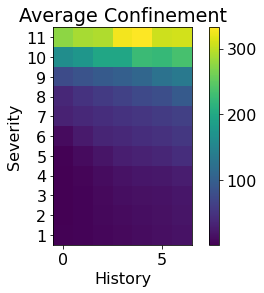

In [5]:
# Calculate average time sentenced for each severity and history level
## And plot
avg_vals = np.zeros([11, 7])
for sever in range(1,12):
    for hist in range(0,7):
        temp = all_data[all_data['severity'] == sever]
        temp = temp[temp['history'] == hist]
        
        avg_vals[sever-1, hist] = np.mean(temp['confine'])
        
avg_vals = np.flipud(avg_vals)

plt.figure()
plt.imshow(avg_vals)
ylabels = list(range(1,12))
ylabels.reverse()
plt.yticks(list(range(0,11)), labels=ylabels)

plt.title('Average Confinement')
plt.xlabel('History')
plt.ylabel('Severity')
plt.colorbar();

In [6]:
# Load in dictionary with values from sentencing grids 
# and remake 'time' column using that
with open('../generated_data/grid_dictionary.json') as json_file:
    grid_dict = json.load(json_file)
    
for i in all_data.index:
    key_ = str(all_data.loc[i,'sentyear']) + '_' + str(all_data.loc[i,'severity']) + '_' + str(all_data.loc[i,'history'])
    all_data.at[i,'time'] = grid_dict[key_]

In [7]:
all_data

,sentyear,sex,race,Agecat,offtype,Offense,severity,history,time,confine
0,2019,1,2,3,7,81.0,4,0,12.0,0.00
1,2019,1,2,5,1,39.0,4,0,12.0,12.03
2,2019,1,1,3,1,39.0,4,0,12.0,12.00
3,2019,1,1,5,1,39.0,4,0,12.0,0.00
4,2019,1,1,5,1,39.0,4,0,12.0,0.00
...,...,...,...,...,...,...,...,...,...,...
258647,2002,1,1,4,3,71.0,9,6,158.0,156.50
258648,2002,1,1,3,3,71.0,9,6,158.0,220.00
258649,2002,1,1,5,3,71.0,9,6,158.0,158.00
258650,2002,1,1,7,2,40.0,4,0,12.0,0.00


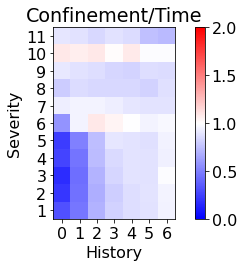

In [8]:
## Calculate average ratio of time sentenced to time prescribed from table
avg_ratio = np.zeros([11, 7])
for sever in range(1,12):
    for hist in range(0,7):
        temp = all_data[all_data['severity'] == sever]
        temp = temp[temp['history'] == hist]
        
        avg_ratio[sever-1, hist] = np.mean(temp['confine']/temp['time'])
        
avg_ratio = np.flipud(avg_ratio)

plt.figure()
plt.imshow(avg_ratio, cmap='bwr')
ylabels = list(range(1,12))
ylabels.reverse()
plt.yticks(list(range(0,11)), labels=ylabels)
plt.xticks(list(range(0,7)))
plt.clim([0,2])

plt.title('Confinement/Time')
plt.xlabel('History')
plt.ylabel('Severity')
plt.colorbar()

plt.tight_layout()

Text(0, 0.5, 'Severity')

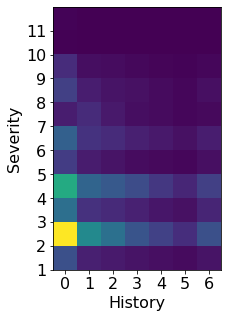

In [41]:
# Make a 2d histogram of how many people are in each bin 

plt.figure(figsize=(3,5))
h = np.histogram2d(all_data['history'], all_data['severity'], bins=[7,11])[0]

plt.imshow(np.flipud(h.T))
ylabels = list(range(1,12))
ylabels.reverse()
plt.yticks(np.array((range(1,12)))-0.5, labels=ylabels)
plt.xticks(list(range(0,7)))

plt.xlabel('History')
plt.ylabel('Severity')

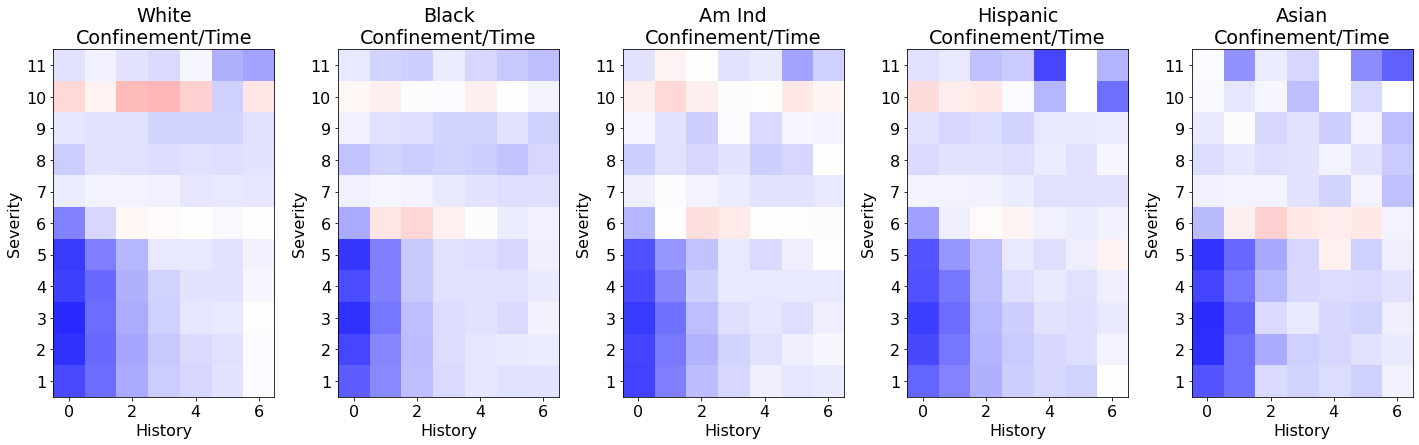

In [10]:
race_dict = meta_map['race']

plt.figure(figsize=(20,10))
for race in range(1,6):
    all_data_race = all_data[all_data['race'] == race]
    avg_ratio = np.zeros([11, 7])
    for sever in range(1,12):
        for hist in range(0,7):
            temp = all_data_race[all_data_race['severity'] == sever]
            temp = temp[temp['history'] == hist]

            avg_ratio[sever-1, hist] = np.mean(temp['confine']/temp['time'])

    avg_ratio = np.flipud(avg_ratio)
    
    plt.subplot(1,5,race)
    plt.imshow(avg_ratio, cmap='bwr')
    ylabels = list(range(1,12))
    ylabels.reverse()
    plt.yticks(list(range(0,11)), labels=ylabels)

    plt.title(f'{race_dict[race]}\nConfinement/Time')
    plt.xlabel('History')
    plt.ylabel('Severity')
    plt.clim([0,2])
plt.tight_layout()

plt.savefig('grid_heatmap_race.png', dpi=300, bbox_inches='tight')

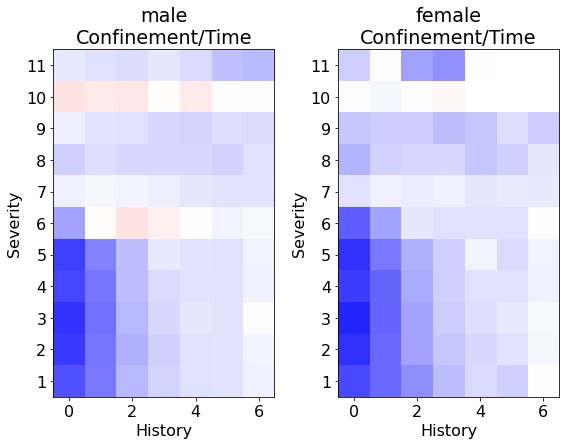

In [11]:
sex_dict = meta_map['sex']

plt.figure(figsize=(20,10))
for sex in range(1,3):
    all_data_sex = all_data[all_data['sex'] == sex]
    avg_ratio = np.zeros([11, 7])
    for sever in range(1,12):
        for hist in range(0,7):
            temp = all_data_sex[all_data_sex['severity'] == sever]
            temp = temp[temp['history'] == hist]

            avg_ratio[sever-1, hist] = np.mean(temp['confine']/temp['time'])

    avg_ratio = np.flipud(avg_ratio)
    
    plt.subplot(1,5,sex)
    plt.imshow(avg_ratio, cmap='bwr')
    ylabels = list(range(1,12))
    ylabels.reverse()
    plt.yticks(list(range(0,11)), labels=ylabels)

    plt.title(f'{sex_dict[sex]}\nConfinement/Time')
    plt.xlabel('History')
    plt.ylabel('Severity')
    plt.clim([0,2])
plt.tight_layout()
plt.savefig('grid_heatmap_sex.png', dpi=300, bbox_inches='tight')